## Importer les librairies

In [64]:
using CSV, DataFrames, Distributions, Gadfly, GLM, Plots
using Distances
import StatsBase       # Pour la standardisation des variables
include("functions.jl")
using LinearAlgebra
using Statistics

## Traiter les données

In [3]:
data = CSV.read("../train.csv")
y_train = data[end]


X_train = data[2:end-1] #omit id and diagnosis

data_test = CSV.read("../test.csv")
X_test = data_test[2:end]

id_test = data_test[1]


println(size(X_train))
println(size(X_test))

length_train = size(X_train)[1]
length_test = size(X_train)[1]


new_X = vcat(X_train, X_test)


(455, 10)
(114, 10)


,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,16.641,21.3452,110.798,901.347,0.112388,0.145148,0.153247,0.0920613
2,13.6884,21.1035,90.5878,578.09,0.0941204,0.101193,0.035445,0.0235371
3,12.9131,14.3055,85.3309,511.539,0.0863069,0.136213,0.13536,0.0403623
4,12.9474,15.1198,86.2821,539.445,0.0925851,0.0849802,0.0937507,0.0347676
5,19.4972,24.8959,127.491,1200.37,0.101691,0.0989018,0.166237,0.0910854
6,17.9685,23.9732,113.391,995.763,0.0879695,0.0705786,0.0574004,0.0484731
7,23.3328,26.9409,158.255,1685.51,0.113154,0.208636,0.352201,0.162356
8,14.2786,19.7755,97.6468,627.095,0.076918,0.224775,0.30016,0.077536
9,15.1174,17.6523,97.2838,674.5,0.11765,0.129638,0.153654,0.086759


In [4]:
X = convert(Array{Float64}, new_X)

Z = standardize(X)

# Décomposition en valeurs singulières de la matrice rectangulaire Z
F = svd(Z)

# Extraction de la matrice U
U = F.U

# Extraction de la matrice V
V = F.V

# Extraction des valeurs singulières
γ = F.S

10-element Array{Float64,1}:
 55.71037587860673
 37.79295983939696
 22.410970566292534
 16.862398849558208
 14.661048168194533
  8.481287124207212
  6.826908502968392
  4.451200683899216
  2.6590076981121036
  1.041803968620491

## Visualiser les données

<img id="myimage" src="pair.png" style=" height:500px; width:500px;">





## Version Agrandie par souci de lisibilité


<div class="img-zoom-container", style="overflow:auto; height:550px; width:5669px;">
  <img id="myimage" src="pair.png" style=" height:5669px; width:5669px;">>
</div>


In [ ]:
Gadfly.set_default_plot_size(150cm, 150cm)

matrix = Array{Plot}(undef, 10, 10)

column = names(train)[2:end-1]
i = 1
for c1 in column
    j = 1
    for c2 in column
        if (i == j)
            matrix[i,j] = plot(train, x = c1, Geom.histogram(bincount = 30), color = :diagnosis)
        else
            matrix[i,j] = plot(train, x = c1, y = c2, color = :diagnosis)
        end
        j+=1
    end 
    i+=1
end 


grid = gridstack(matrix)

## Faire le modele KNN

In [5]:
function calculateDist(vec1, vec2)
    return euclidean(vec1,vec2)
end

function findMin(n, tab, used_indexes)
    mini_pos = 1
    mini = tab[mini_pos]
    
    for i = 2:length(tab)
        if (tab[i] < mini && !(i in used_indexes))
            mini_pos = i
            mini = tab[i]
        end
    end
    return mini_pos
end


function findIndexesNSmallest(n, tab)
    temp = copy(tab)
    indexes = []
    for i = 1:n
        new_index = findMin(n, temp, indexes)
        push!(indexes, new_index)
    end
    

    return indexes
end

function predict(k, X_train, y_train, X_test) #works best with odd k    
    nb_data = size(X_train)[1]
    
    distances = []
    for elem in 1:nb_data
        push!(distances, calculateDist(X_test, X_train[elem, :]))
    end
    
    indexes_distances = findIndexesNSmallest(k, distances)
    
    nb_0 = 0
    for index in indexes_distances
        if (y_train[index] == 0)
            nb_0 += 1
        end
    end
    
    return convert(Int8, (nb_0 < k - nb_0))
    
end

function knn(k, X_train, y_train, X_test)
    ans = []
    for elem in 1:size(X_test)[1]
        push!(ans, predict(k, X_train, y_train, X_test[elem, :]))
    end
    return ans
end




knn (generic function with 1 method)

## K-cross validation

In [6]:
# K-cross validation
function findAllIndexes(length, nb_blocks)
    return [(convert(Int16, floor((i-1)*length/nb_blocks))+1, convert(Int16, floor(i*length/nb_blocks))) for i = 1:nb_blocks]
end

function countTFPN(t_label, predictions)
    TP, FP, FN, TN = 0, 0, 0, 0
    taille = size(t_label)[1]
    for i = 1:taille
        if(t_label[i] == 1 && predictions[i] == 1)
            TP += 1
        elseif(t_label[i] == 1 && predictions[i] == 0)
            FN += 1
        elseif(t_label[i] == 0 && predictions[i] == 1)
            FP += 1
        elseif(t_label[i] == 0 && predictions[i] == 0)
            TN += 1
        end
            
    end
    return TP, FP, FN, TN
end

function computeMetrics(t_label, predictions)
    TP, FP, FN, TN = countTFPN(t_label, predictions)
    precision, recall, accuracy = (TP/(TP + FP)), (TP/(TP + FN)), ((TP+TN)/(TP + FP + FN + TN))
    return [precision, recall, accuracy]
end

function split_train_test(X, y, index)
    sub_X_train = [X[1 : index[1]-1, :]; X[index[2] : end, :]]
    sub_X_test = X[index[1] : index[2], :]
    sub_y_train = [y[1 : index[1]-1]; y[index[2] : end]]
    true_y_test = y[index[1] : index[2]]
    return sub_X_train, sub_X_test, sub_y_train, true_y_test
end


function KCrossValidation(k, X, y, nb_blocks = 15)
    indexes = findAllIndexes(size(X_test)[1],nb_blocks)
    ans = []
    for interval = indexes
        sub_X_train, sub_X_test, sub_y_train, true_y_test = split_train_test(X, y, interval)
        sub_y_test =  knn(k, sub_X_train, sub_y_train, sub_X_test)
        push!(ans, computeMetrics(true_y_test, sub_y_test))
    end
    temp = mean(ans)
    return temp
end


KCrossValidation (generic function with 2 methods)

## Trouver le K qui minimise l'erreur selon les métriques

In [7]:
mat = γ[1] *U[:, 1]*V[:,1]'

X_train = mat[1:length_train, :]
X_test = mat[length_train+1:end, :]

println(size(X_train))
println(size(X_test))
println(size(y_train))
println(size(y_test))



(455, 10)
(114, 10)
(455,)


LoadError: UndefVarError: y_test not defined

In [130]:
spy_matrix = Array{AbstractFloat}(undef, 10, 10)
spy_matrix_text = Array{Plots.PlotText}(undef, 10, 10)
for j = 1:10
    println("Index : ", j)
    
    mat = γ[1] *U[:, 1]*V[:,1]'
    for k = 2:j
        mat += γ[k] *U[:, k]*V[:,k]'
    end
    

    X_train = mat[1:length_train, :]

    X_test = mat[length_train+1:end, :]
    metrics = []
    gen_temp = 1:2:19
    for i = 1:2:19
        temp = KCrossValidation(i, X_train, y_train)
        if (i ==  1)
            metrics = [[elem] for elem = temp]
        else
            taille = size(temp)[1]
            for index = 1:taille
                push!(metrics[index], temp[index])
            end
        end

    end
    ks = [i for i = gen_temp]

    
    precision = metrics[1]
    recall = metrics[2]
    for index = 1:length(precision)
        f1 = 2*(precision[index] * recall[index])/(precision[index] + recall[index])
        println("F1 score ",index*2 - 1,  "NN : ", f1)
        spy_matrix[index,j] = f1
        spy_matrix_text[index,j] = Plots.text(round(f1, digits=4),9)
    end
    
end


Index : 1
F1 score 1NN : 0.8891101431238333
F1 score 3NN : 0.9159625362172359
F1 score 5NN : 0.9152348224513173
F1 score 7NN : 0.9240117521367521
F1 score 9NN : 0.9240117521367521
F1 score 11NN : 0.9159625362172359
F1 score 13NN : 0.9159625362172359
F1 score 15NN : 0.9159625362172359
F1 score 17NN : 0.9159625362172359
F1 score 19NN : 0.9159625362172359
Index : 2
F1 score 1NN : 0.8991426611796983
F1 score 3NN : 0.9336109458655562
F1 score 5NN : 0.9277777777777777
F1 score 7NN : 0.9336109458655562
F1 score 9NN : 0.9160838218448891
F1 score 11NN : 0.8992931164642096
F1 score 13NN : 0.9169392287502525
F1 score 15NN : 0.9338885583977791
F1 score 17NN : 0.9027008547008547
F1 score 19NN : 0.90791709140333
Index : 3
F1 score 1NN : 0.9002261978202755
F1 score 3NN : 0.9388560157790926
F1 score 5NN : 0.9220883534136545
F1 score 7NN : 0.9388560157790926
F1 score 9NN : 0.9388560157790926
F1 score 11NN : 0.9247914581247915
F1 score 13NN : 0.9338885583977791
F1 score 15NN : 0.9388560157790926
F1 scor

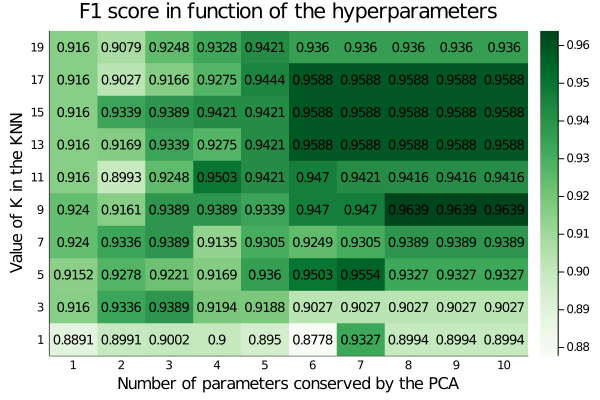

In [135]:
Gadfly.set_default_plot_size(12cm, 12cm)
Axis_k = ["1","3","5","7","9","11","13","15","17","19"]
Axis_PCA = ["1","2","3","4","5","6","7","8","9","10"]
p = heatmap(Axis_PCA,Axis_k,spy_matrix,
    ylabel ="Value of K in the KNN",
    xlabel = "Number of parameters conserved by the PCA",
    title = "F1 score in function of the hyperparameters",
    c=:Greens
)
annotate!( vec(tuple.((1:length(Axis_PCA))'.-0.5, (1:length(Axis_k)).-0.5, spy_matrix_text)) )


In [139]:
plot(x=ks, y=metrics[1], Geom.line, Guide.xlabel("K"), Guide.ylabel(y_titles[1]))

LoadError: UndefVarError: metrics not defined

In [10]:
plot(x=ks, y=metrics[2], Geom.line, Guide.xlabel("K"), Guide.ylabel(y_titles[2]))

LoadError: UndefVarError: metrics not defined

In [11]:
plot(x=ks, y=metrics[3], Geom.line, Guide.xlabel("K"), Guide.ylabel(y_titles[3]))

LoadError: UndefVarError: metrics not defined

## Rouler le code avec ce K

In [140]:
k = 9

mat = γ[1] *U[:, 1]*V[:,1]'
for i = 2:8
    mat += γ[i] *U[:, i]*V[:,i]'
end
X_train = mat[1:length_train, :]
X_test = mat[length_train+1:end, :]

y_test = knn(k, X_train, y_train, X_test)
prediction = DataFrame(id = id_test, diagnosis = y_test)
CSV.write("KNN.csv",prediction)

"KNN.csv"